In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from pathlib import PurePath
from sklearn.preprocessing import MinMaxScaler
% matplotlib inline
bundle_root = os.environ.get('LABS_BUNDLE_ROOT', '/labs')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

In [3]:
dataset_train = pd.read_csv(PurePath(bundle_root, 'data/raw/trainset.csv'))

In [4]:
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [5]:
trainset = dataset_train.iloc[:,1:2].values

In [6]:
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(trainset)

In [7]:
training_scaled

array([[0.01011148],
       [0.01388614],
       [0.01690727],
       ...,
       [0.97543954],
       [0.9674549 ],
       [0.96072522]])

In [8]:
x_train = []
y_train = []

In [9]:
for i in range(60,1259):
    x_train.append(training_scaled[i-60:i, 0])
    y_train.append(training_scaled[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)

In [10]:
x_train.shape

(1199, 60)

In [11]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [13]:
# define regressor
regressor = Sequential()
regressor.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam',loss = 'mean_squared_error')

In [14]:
%%capture
regressor.fit(x_train,y_train,epochs = 100, batch_size = 32)

Epoch 1/100
1199/1199 [==============================] - 10s 8ms/step - loss: 0.0399
Epoch 2/100
1199/1199 [==============================] - 7s 6ms/step - loss: 0.0049
Epoch 3/100
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0040
Epoch 4/100
1199/1199 [==============================] - 7s 6ms/step - loss: 0.0038
Epoch 5/100
1199/1199 [==============================] - 8s 7ms/step - loss: 0.0040
Epoch 6/100
1199/1199 [==============================] - 19s 16ms/step - loss: 0.0033
Epoch 7/100
1199/1199 [==============================] - 15s 12ms/step - loss: 0.0033
Epoch 8/100
1199/1199 [==============================] - 11s 9ms/step - loss: 0.0036
Epoch 9/100
1199/1199 [==============================] - 13s 11ms/step - loss: 0.0033
Epoch 10/100
1199/1199 [==============================] - 12s 10ms/step - loss: 0.0032
Epoch 11/100
1199/1199 [==============================] - 12s 10ms/step - loss: 0.0032
Epoch 12/100
1199/1199 [==============================] - 10s 

In [15]:
dataset_test = pd.read_csv(PurePath(bundle_root, 'data/raw/testset.csv'))

In [16]:
real_stock_price = dataset_test.iloc[:,1:2].values

In [17]:
dataset_total = pd.concat((dataset_train['Open'],dataset_test['Open']),axis = 0)
dataset_total.head()

0    357.385559
1    360.122742
2    362.313507
3    365.348755
4    365.393463
Name: Open, dtype: float64

In [22]:
inputs = dataset_total[len(dataset_total) - len(dataset_test)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
inputs.shape

(185, 1)

In [23]:
x_test = []
for i in range(60,185):
    x_test.append(inputs[i-60:i,0])

In [24]:
x_test = np.array(x_test)
x_test.shape

(125, 60)

In [25]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(125, 60, 1)

In [28]:
predicted_price = regressor.predict(x_test)
predicted_price = sc.inverse_transform(predicted_price)

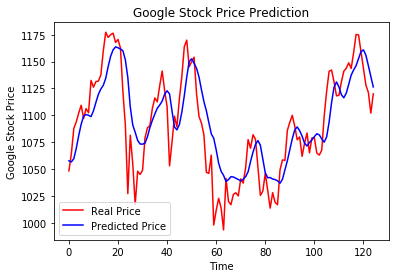

In [29]:
plt.plot(real_stock_price,color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()